<a href="https://colab.research.google.com/github/AntropovDaniil/LSTM/blob/master/LSTM_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install gdown
!pip install tensorflow-gpu

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pandas.util.testing as tm
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=2)
rcParams['figure.figsize'] = 25, 12

np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [0]:
from google.colab import files
files.upload()

In [21]:
!ls

 sample_data  'train_dataset (1).csv'   train_dataset.csv


In [0]:
df = pd.read_csv("train_dataset.csv",
                 parse_dates=['Time'], 
                  index_col="Time")

In [23]:
df.head()

,Day_Type_ID,Total_Carriageway_Flow,Speed_Value,Intencity,Volume,Result
Time,,,,,,
2014-01-01 00:00:00,14,42.0,105.43,168.0,1.593474,0.0
2014-01-01 00:15:00,14,59.0,103.26,236.0,2.285493,0.0
2014-01-01 00:30:00,14,79.0,98.71,316.0,3.201297,0.0
2014-01-01 00:45:00,14,124.0,96.59,496.0,5.135107,0.0
2014-01-01 01:00:00,14,151.0,99.45,604.0,6.073404,0.0


In [0]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

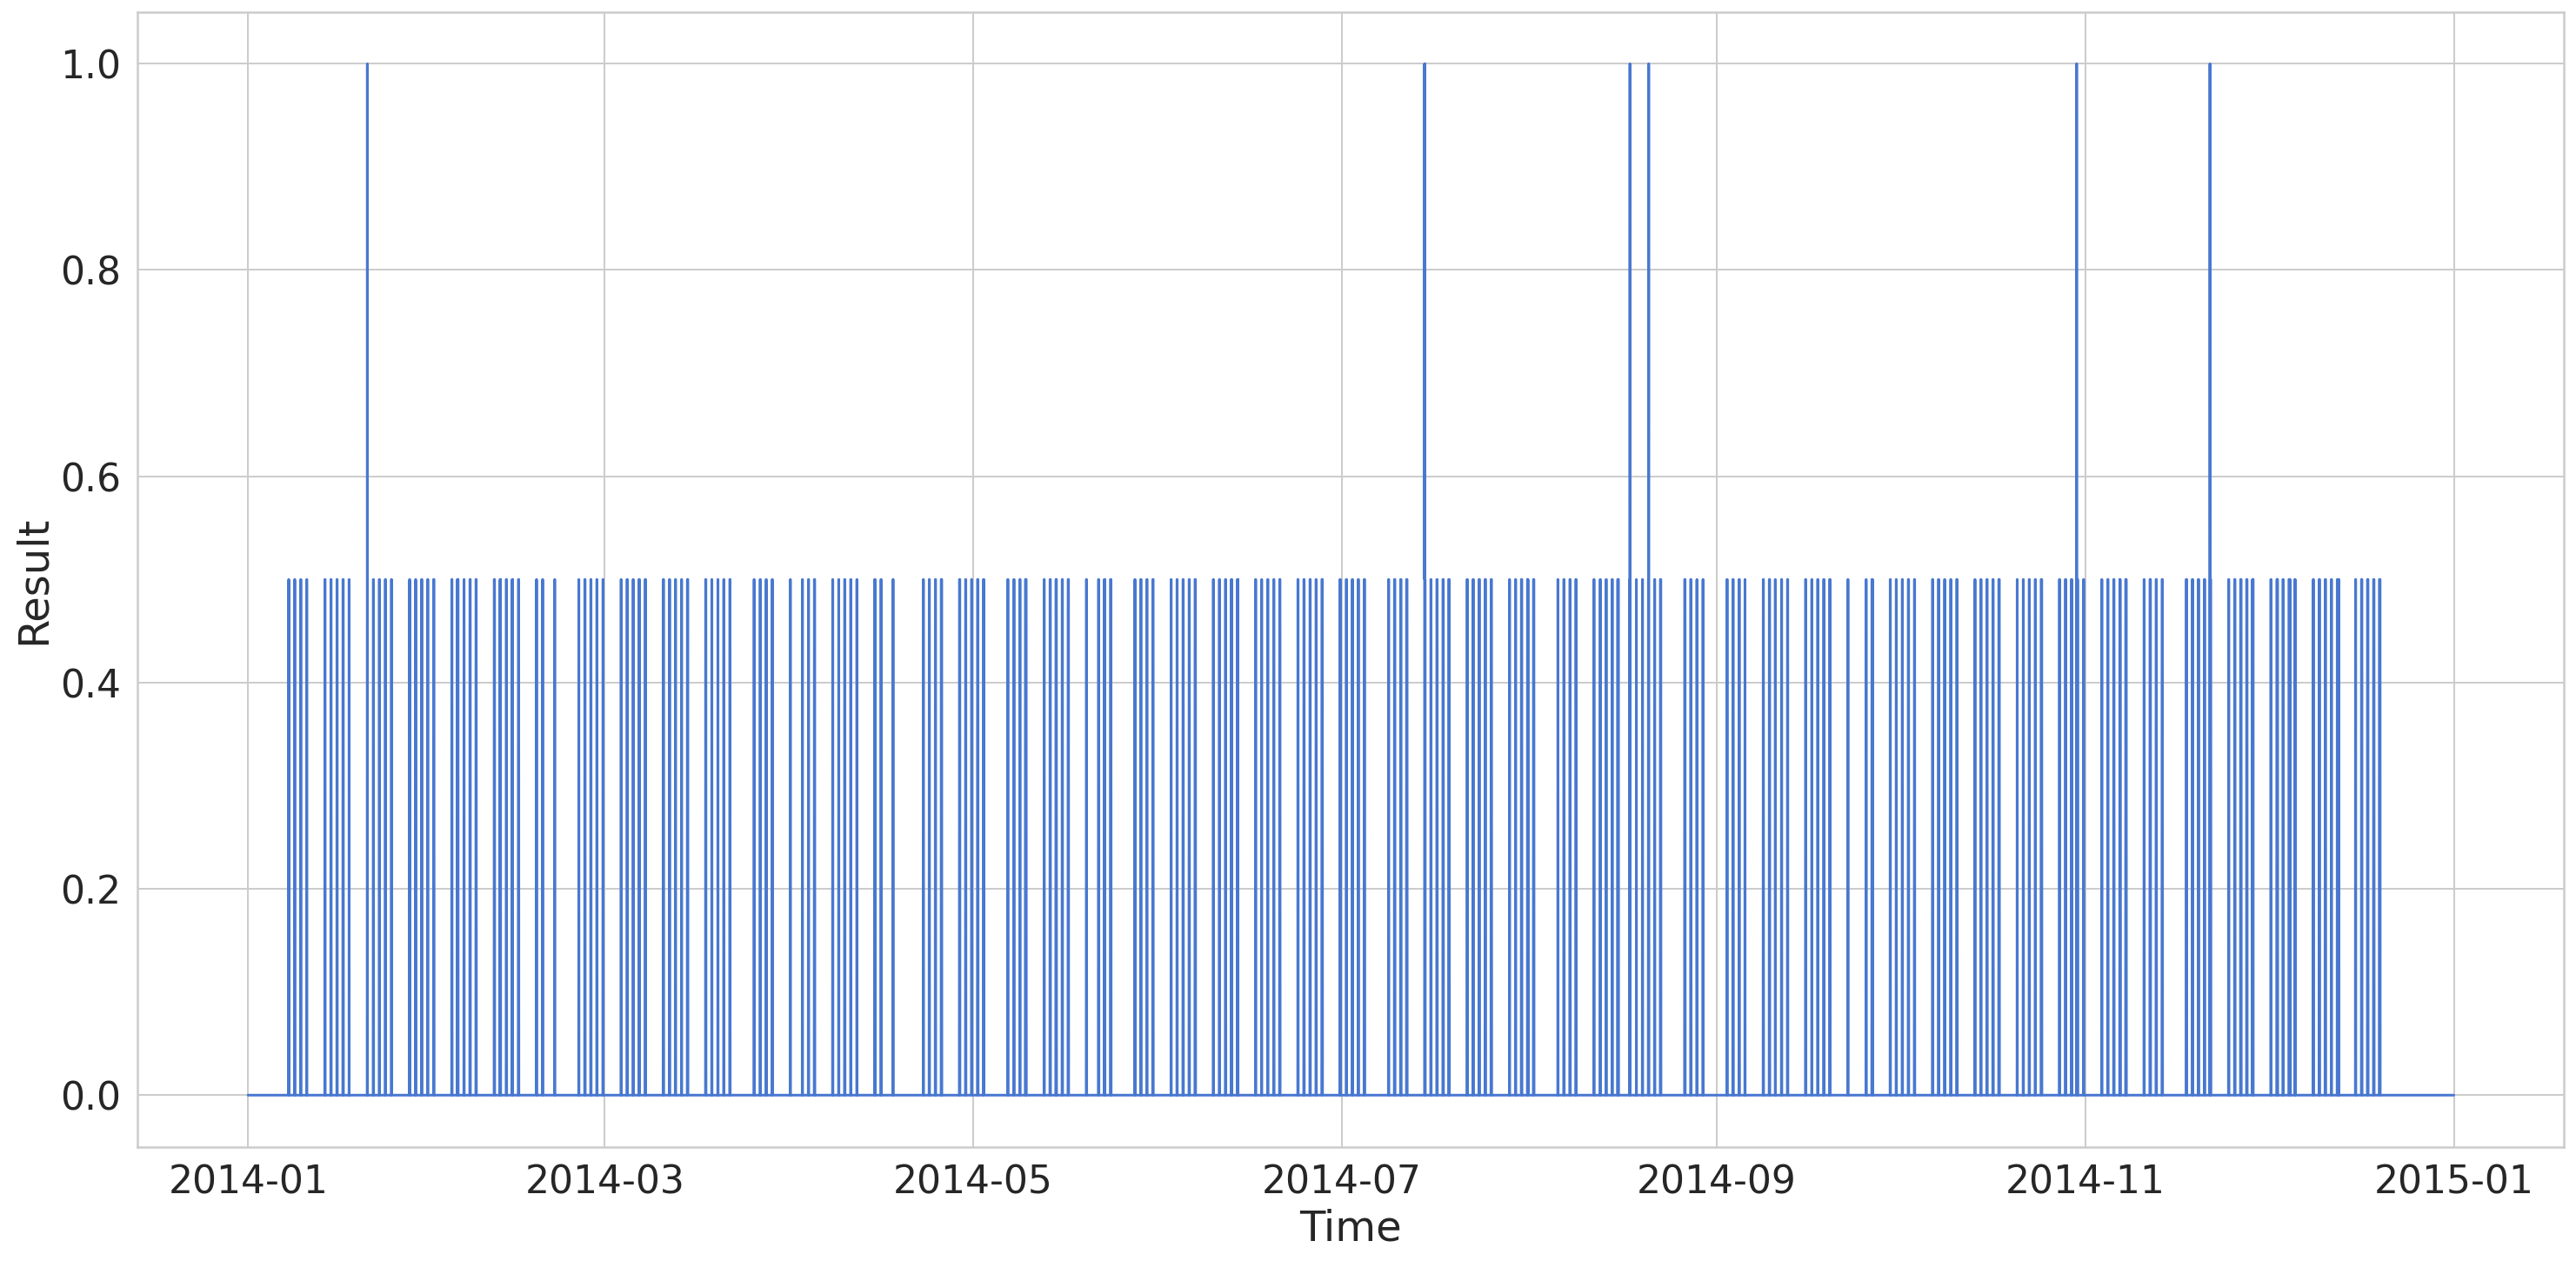

In [28]:
sns.lineplot(x=df.index, y="Result", data=df)

In [29]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

28016 7005


Scaling Data

In [0]:
from sklearn.preprocessing import RobustScaler
f_cols1 = ['Total_Carriageway_Flow', 'Speed_Value', 'Intencity', 'Volume']

f_transformer1 = RobustScaler()
result_transformer = RobustScaler()

f_transformer1 = f_transformer1.fit(train[f_cols1].to_numpy())
result_transformer = result_transformer.fit(train[['Result']])

train.loc[:, f_cols1] = f_transformer1.transform(train[f_cols1].to_numpy())
train['Result'] = result_transformer.transform(train[['Result']])

test.loc[:, f_cols1] = f_transformer1.transform(test[f_cols1].to_numpy())
test['Result'] = result_transformer.transform(test[['Result']])

# Creating Dataset

In [0]:
def create_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        Ys.append(Y.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

In [0]:
TIME_STEPS = 24
x_train, y_train = create_dataset(train, train.Result, time_steps = TIME_STEPS)
x_test, y_test = create_dataset(test, test.Result, time_steps = TIME_STEPS)

In [33]:
print(x_train.shape, y_train.shape)

(27992, 24, 10) (27992,)


# Creation of Neural Network model (LSTM)

In [0]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(x_train.shape[1], x_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_absolute_error', optimizer='adam')

# Training LSTM model

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs_value = 150
batch_size_value = 32

early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0.001,
                           patience=10, 
                           verbose=1, 
                           mode='auto')
check_point = ModelCheckpoint(filepath='drive/My Drive/', 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')

callbacks = [early_stop, check_point]

history = model.fit(
    x_train, y_train, 
    epochs=epochs_value, 
    batch_size=batch_size_value, 
    validation_split=0.1,
    shuffle=True
)

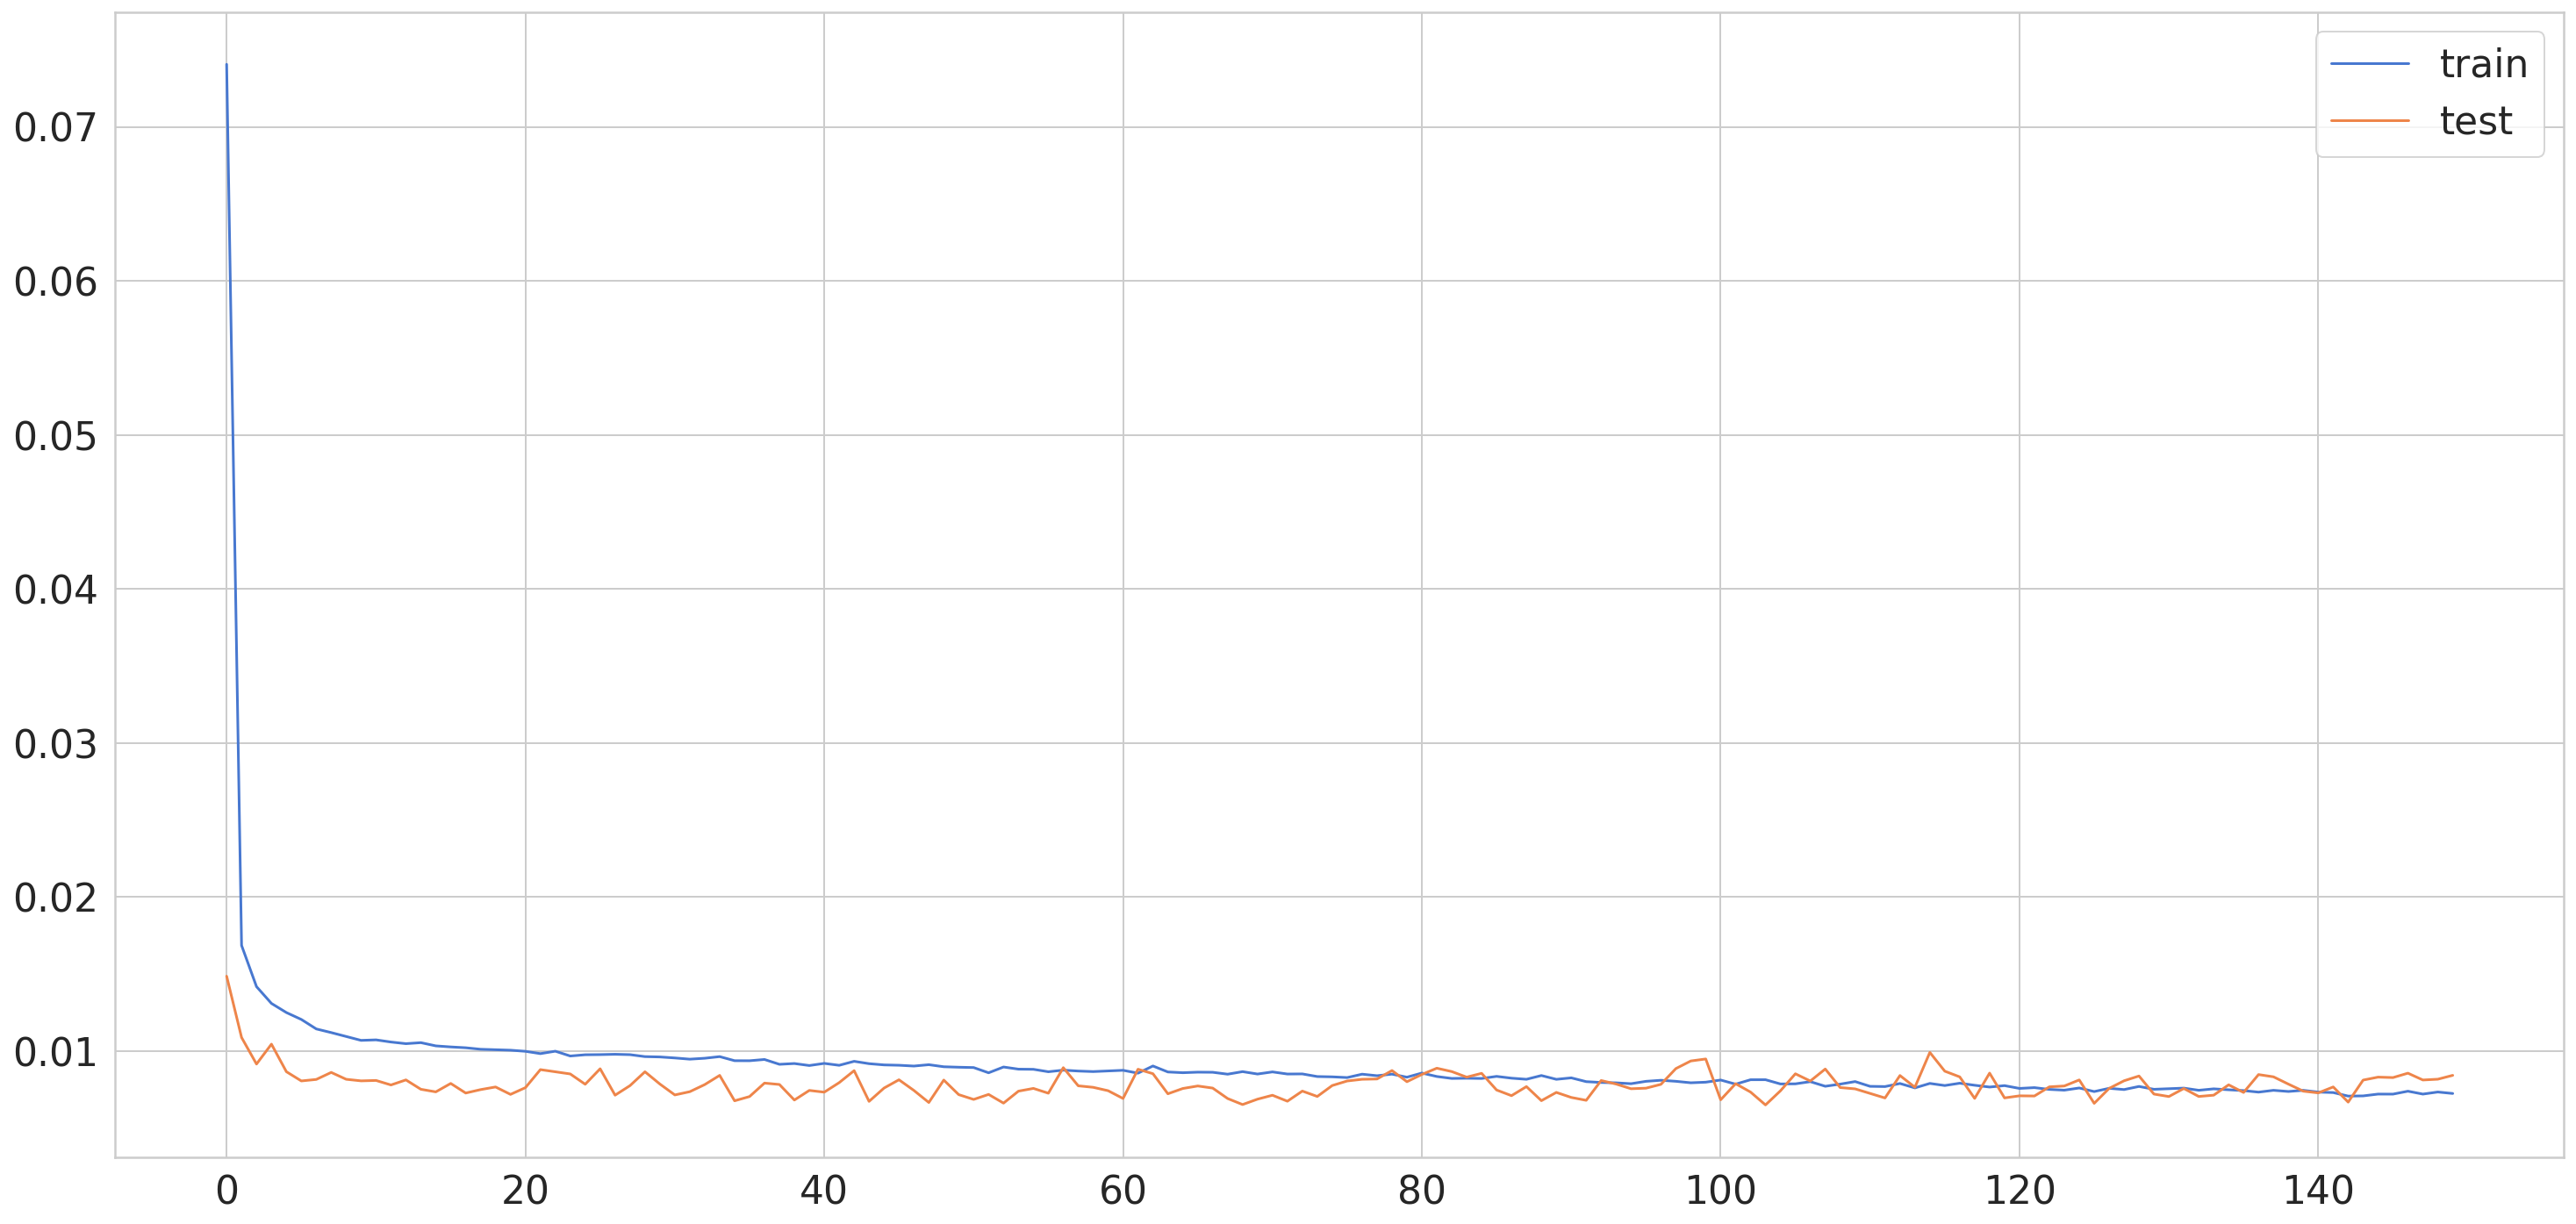

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
y_pred = model.predict(x_test)

In [0]:
y_train_inv = result_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = result_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = result_transformer.inverse_transform(y_pred)

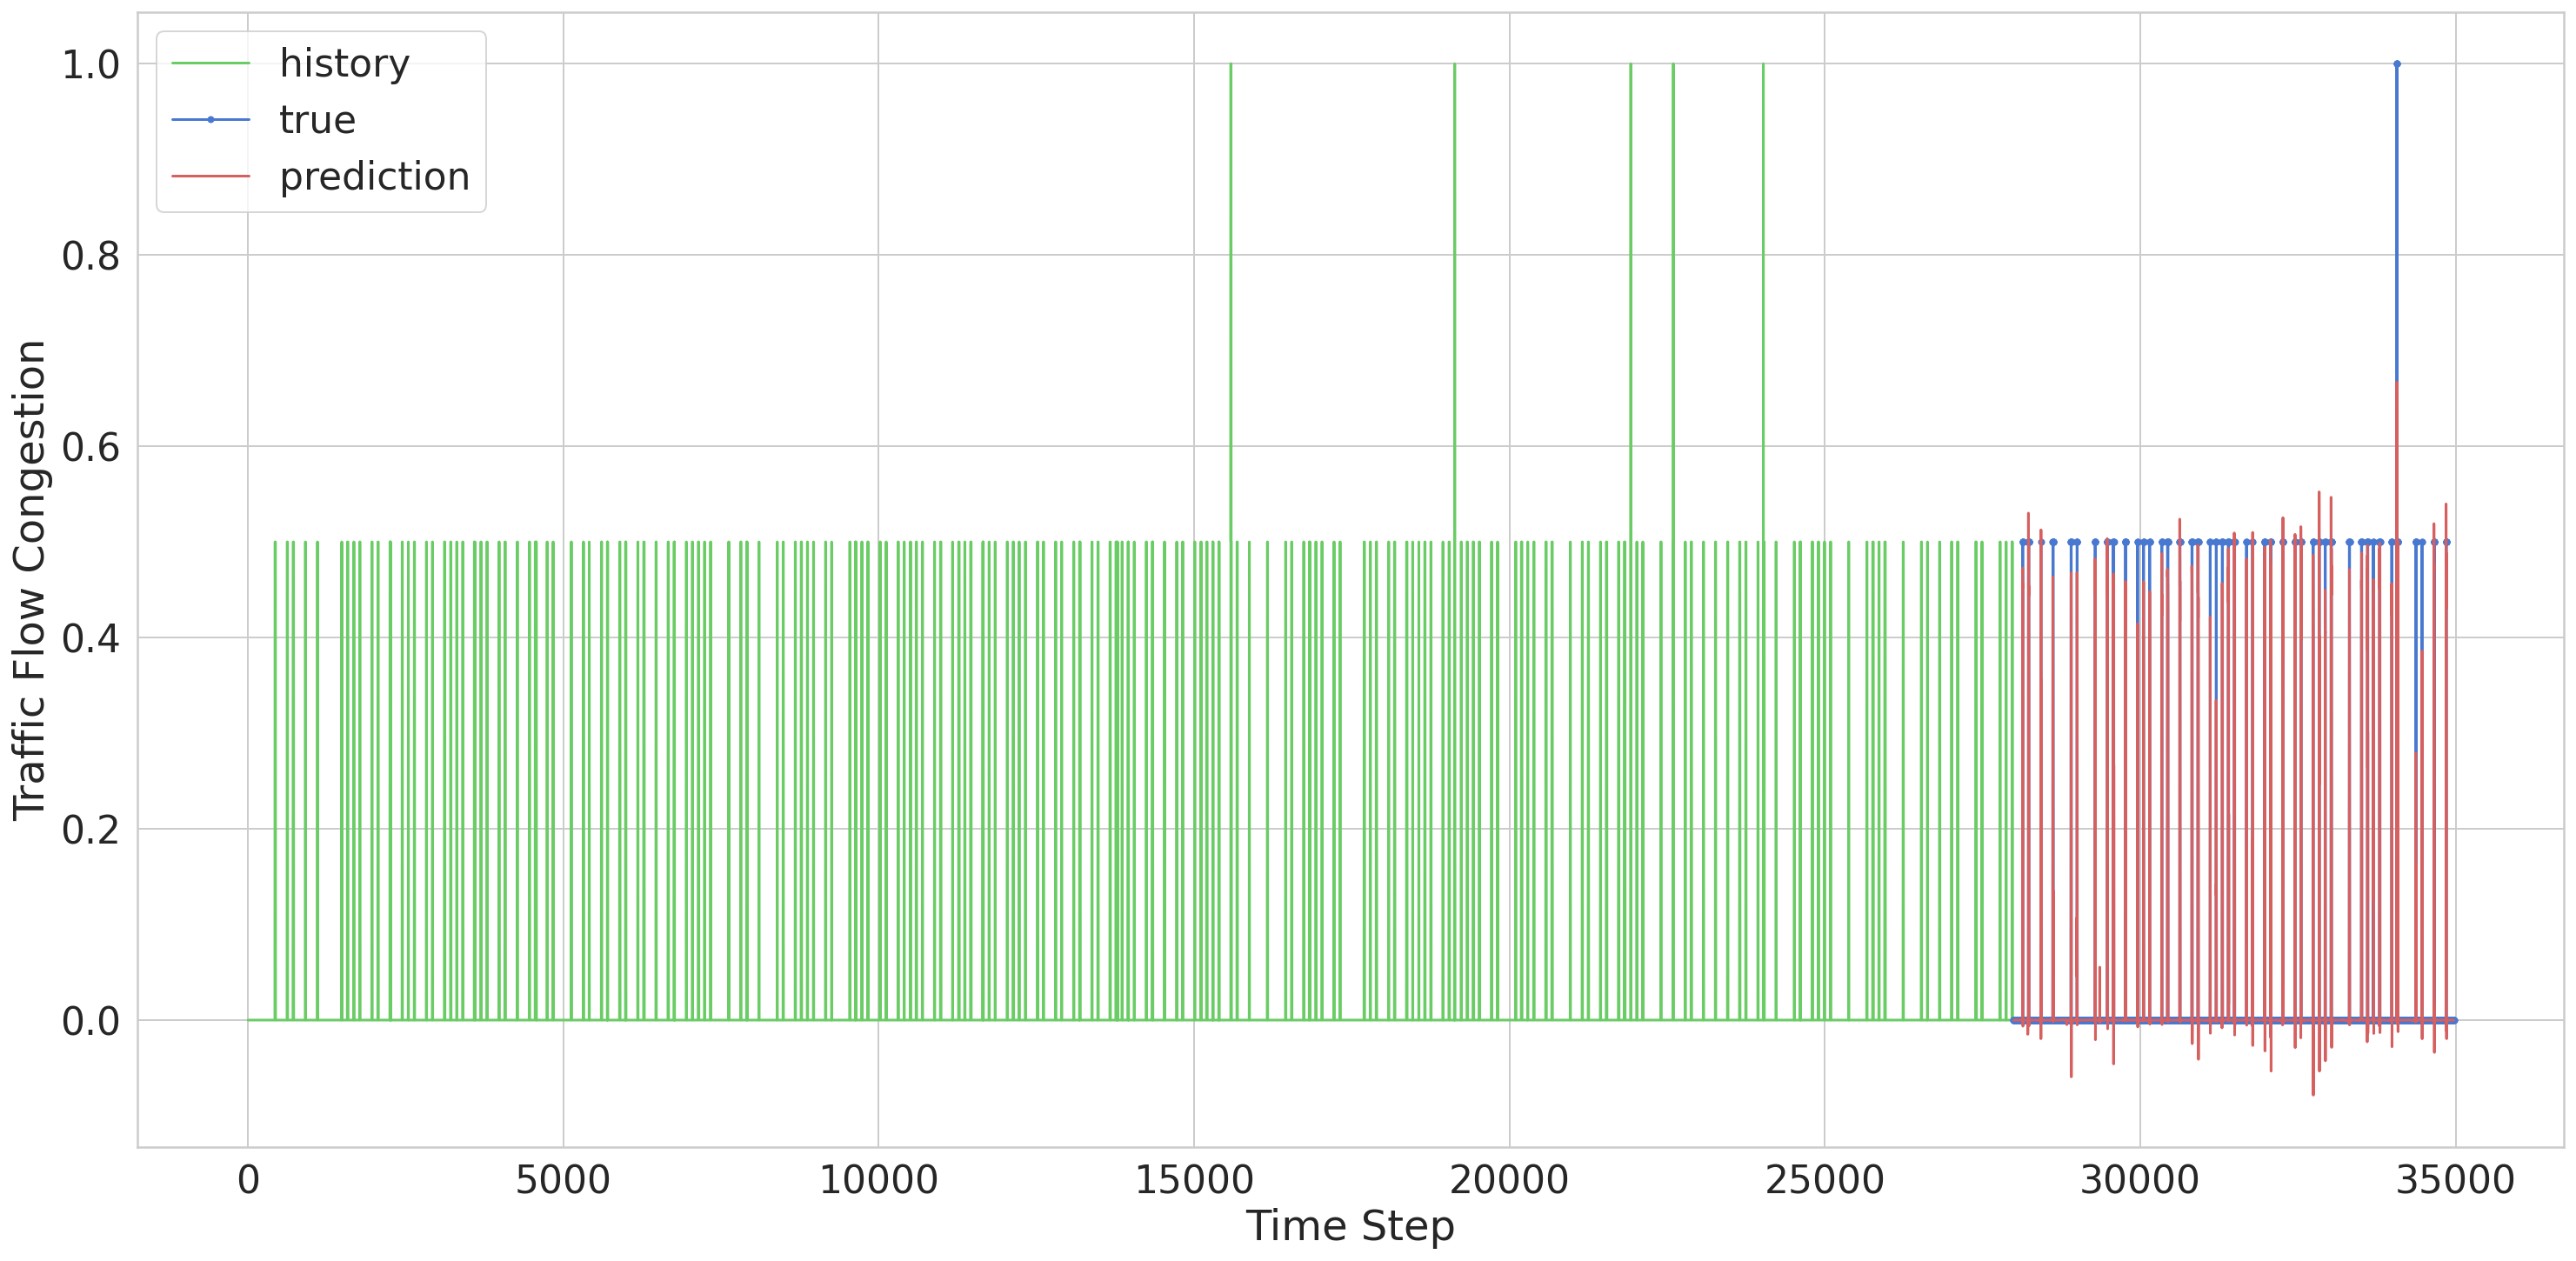

In [40]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Traffic Flow Congestion')
plt.xlabel('Time Step')
plt.legend()
plt.show();

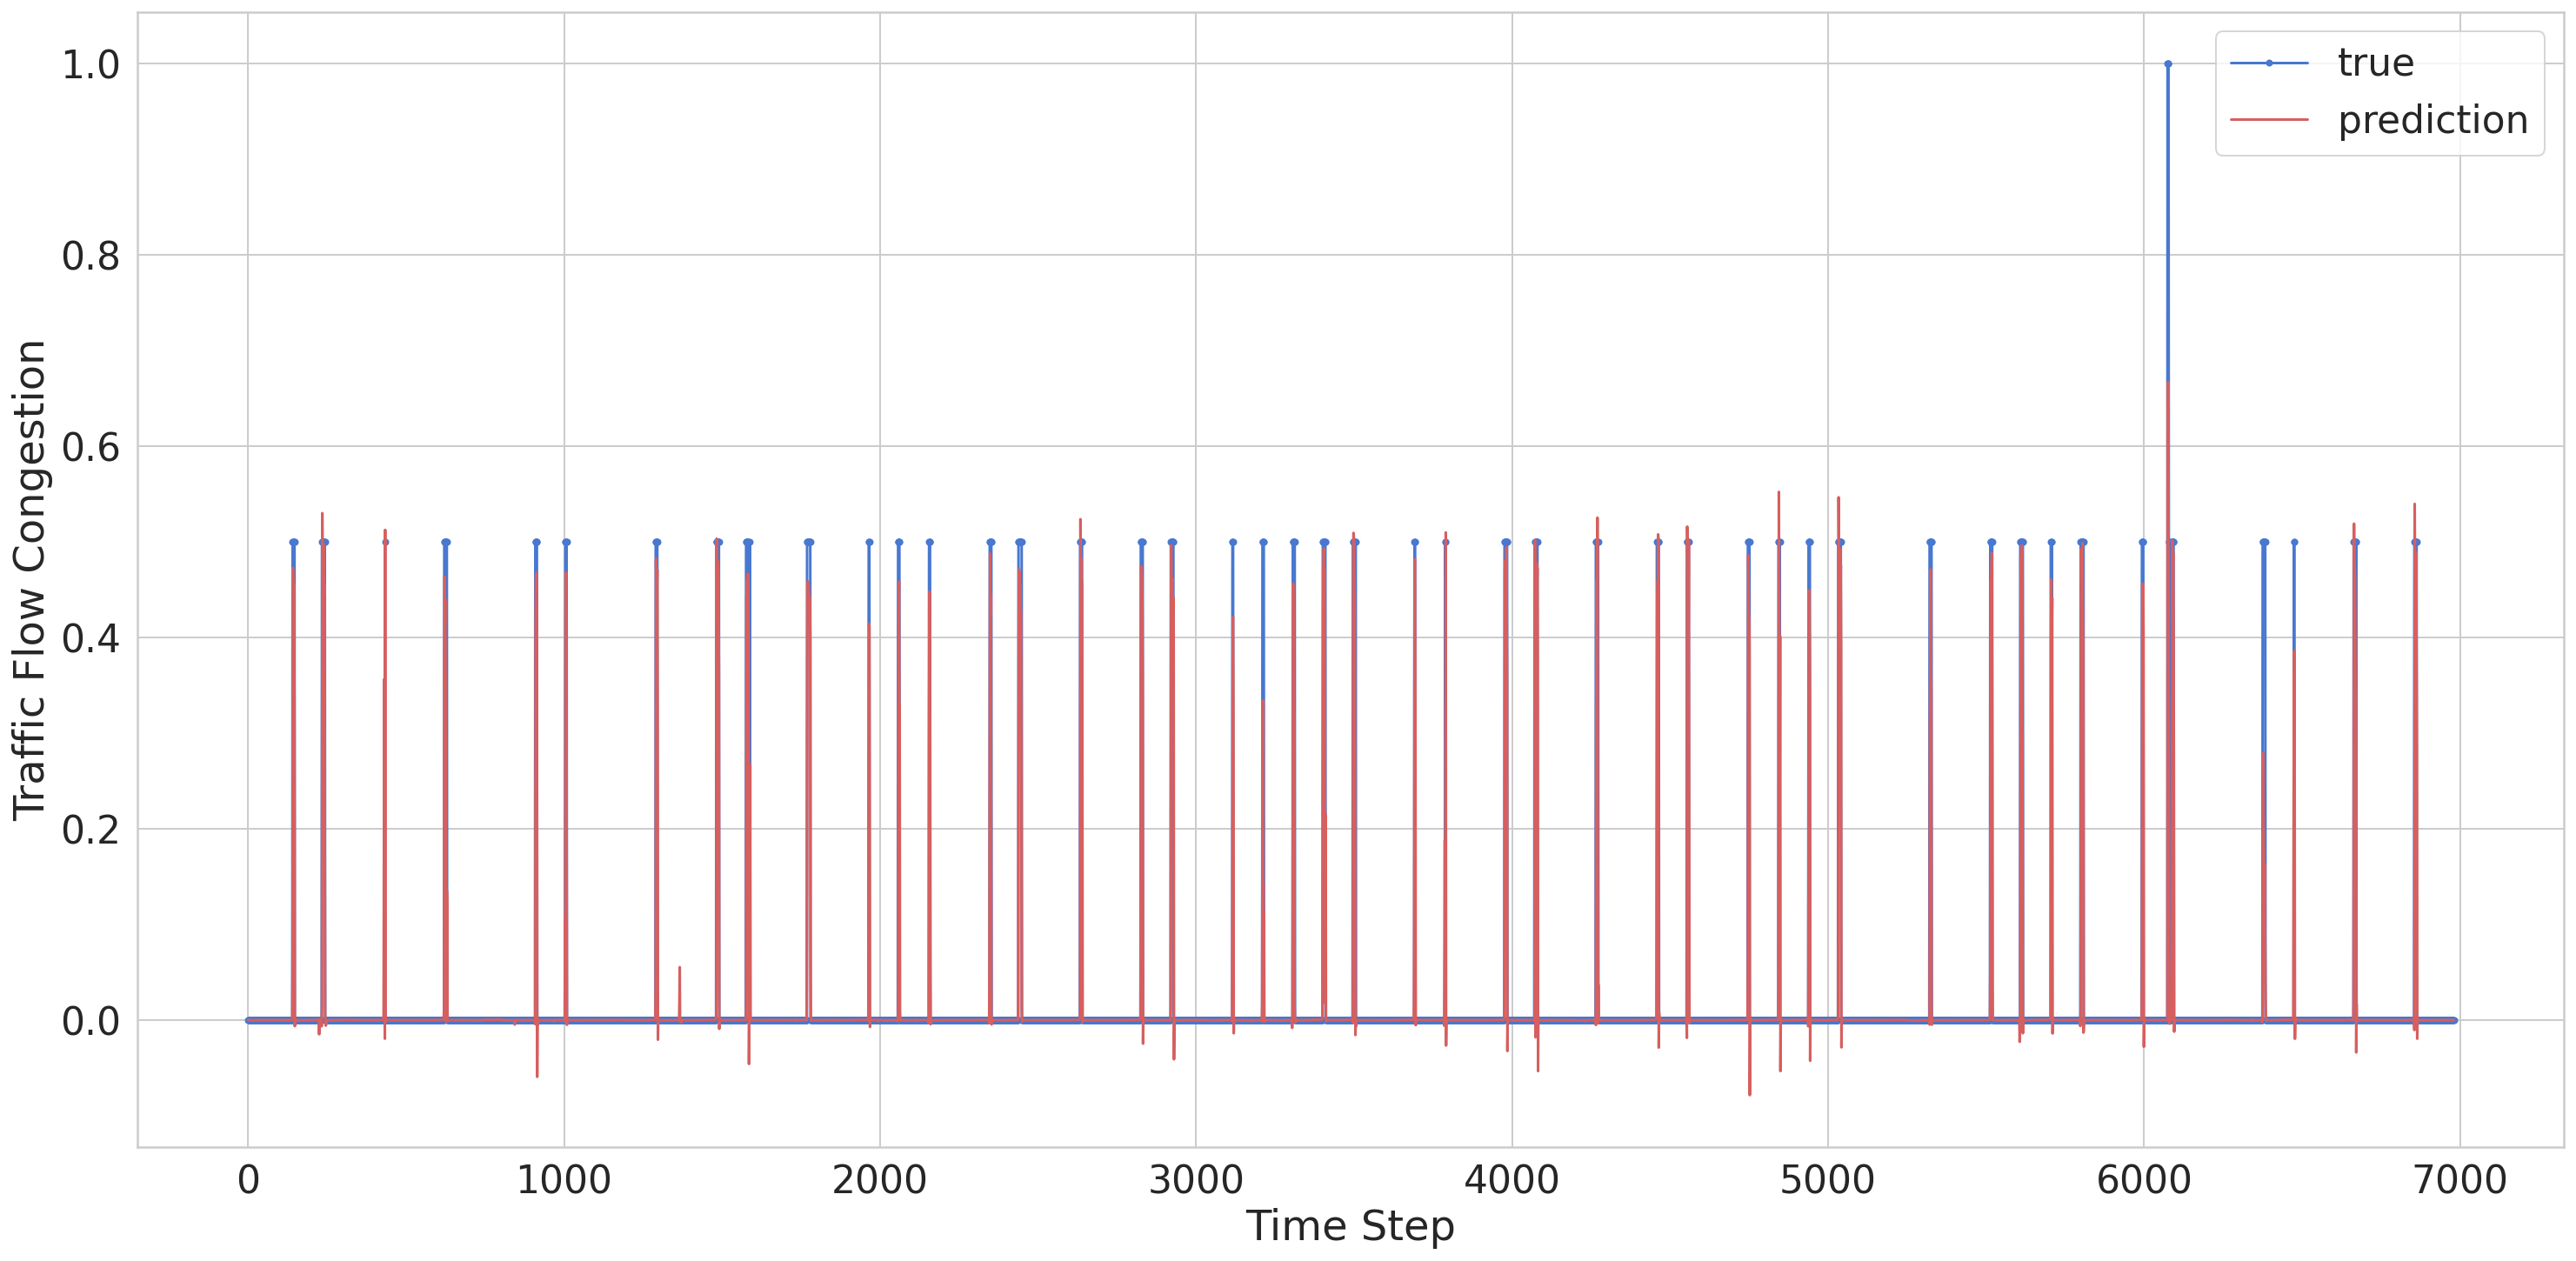

In [41]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Traffic Flow Congestion')
plt.xlabel('Time Step')
plt.legend()
plt.show();